###Node2Vec model using torch geometric with Cora

In [2]:
# First install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install pyg-lib -f https://data.pyg.org/whl/cu118/torch-2.0.0.html
!pip install numpy==1.23.5


Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp311-cp311-linux_x86_64.whl (2267.3 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/cu118/torch-2.0.0.html


In [3]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Verify installations
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch: 2.0.1+cu118
CUDA available: True


In [5]:
# **************** IMPORT DATA ********************
dataset = Planetoid(root='/tmp/Cora', name='Cora')  # Colab compatible path
data = dataset[0]
print(f'\nDataset: {dataset}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = data.to(device)



Dataset: Cora()
Number of nodes: 2708
Number of edges: 10556
Number of classes: 7


In [6]:
# **************** CONSTRUCT THE MODEL ********************
Node2Vec_model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True
).to(device)

loader = Node2Vec_model.loader(
    batch_size=128,
    shuffle=True,
    num_workers=0  # Changed to 0 for Colab compatibility
)

optimizer = torch.optim.SparseAdam(
    list(Node2Vec_model.parameters()),
    lr=0.01
)


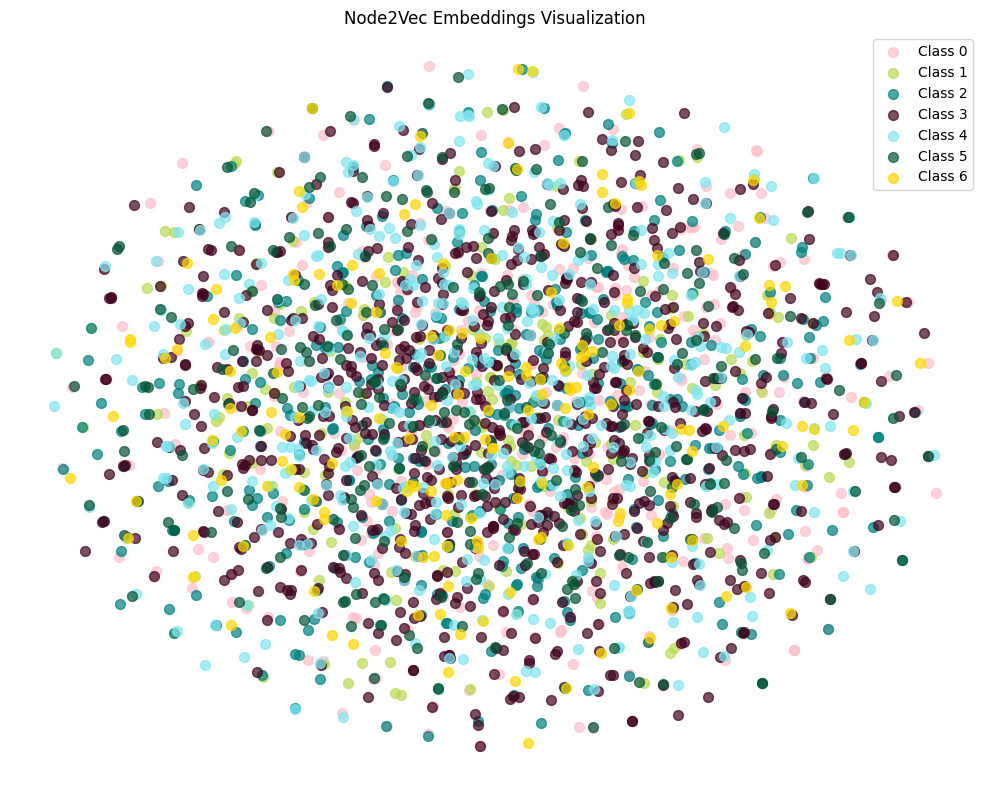

In [7]:
# **************** VISUALIZATION ********************
'Befor Training'
@torch.no_grad()
def plot_point(colors):
    Node2Vec_model.eval()
    z = Node2Vec_model(torch.arange(data.num_nodes, device=device))
    z = z.cpu().numpy()

    # Use PCA if TSNE fails
    try:
        from sklearn.manifold import TSNE
        z_2d = TSNE(n_components=2).fit_transform(z)
    except:
        from sklearn.decomposition import PCA
        z_2d = PCA(n_components=2).fit_transform(z)

    y = data.y.cpu().numpy()
    plt.figure(figsize=(10, 8))

    for i in range(dataset.num_classes):
        plt.scatter(
            z_2d[y == i, 0],
            z_2d[y == i, 1],
            s=50,
            color=colors[i],
            label=f'Class {i}',
            alpha=0.7
        )

    plt.legend()
    plt.title("Node2Vec Embeddings Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420',
    '#7fe5f0', '#065535', '#ffd700'
]
plot_point(colors)


In [8]:
# **************** TRAIN FUNCTION ********************
def train():
    Node2Vec_model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = Node2Vec_model.loss(
            pos_rw.to(device),
            neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()  # Fixed += operator
    return total_loss / len(loader)


In [9]:
# **************** TRAINING LOOP ********************
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')


Epoch: 10, Loss: 1.7387
Epoch: 20, Loss: 0.9725
Epoch: 30, Loss: 0.8701
Epoch: 40, Loss: 0.8436
Epoch: 50, Loss: 0.8348
Epoch: 60, Loss: 0.8308
Epoch: 70, Loss: 0.8273
Epoch: 80, Loss: 0.8264
Epoch: 90, Loss: 0.8269
Epoch: 100, Loss: 0.8236


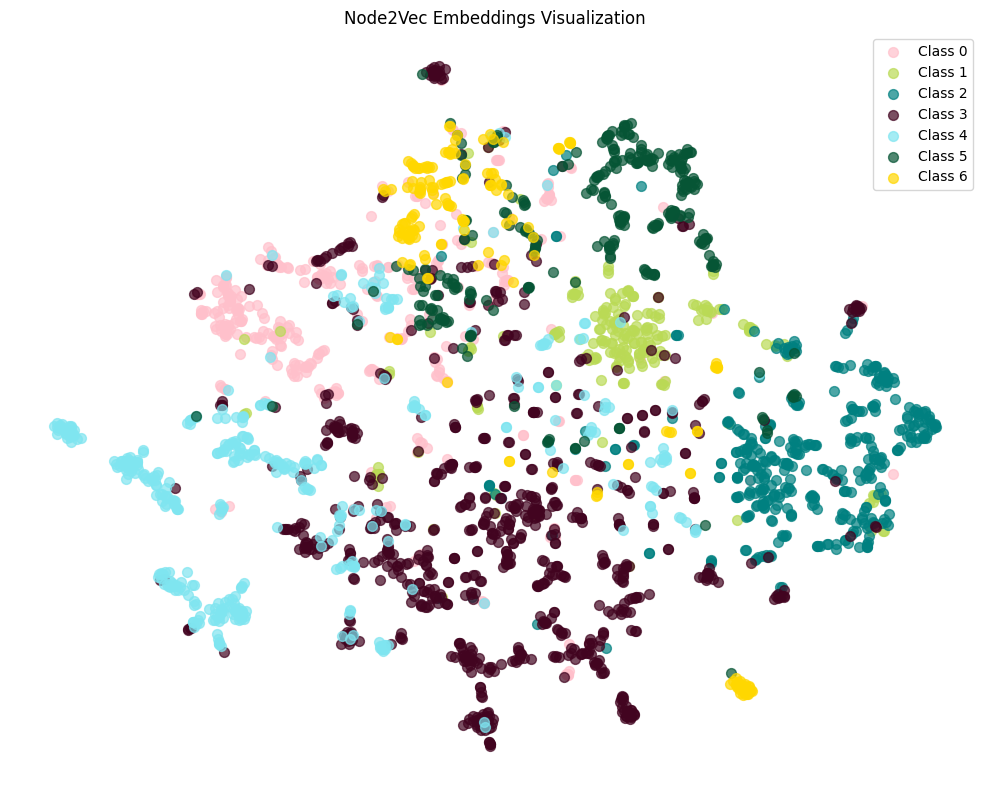

In [10]:
# **************** VISUALIZATION ********************
'After Training'

@torch.no_grad()
def plot_point(colors):
    Node2Vec_model.eval()
    z = Node2Vec_model(torch.arange(data.num_nodes, device=device))
    z = z.cpu().numpy()

    # Use PCA if TSNE fails
    try:
        from sklearn.manifold import TSNE
        z_2d = TSNE(n_components=2).fit_transform(z)
    except:
        from sklearn.decomposition import PCA
        z_2d = PCA(n_components=2).fit_transform(z)

    y = data.y.cpu().numpy()
    plt.figure(figsize=(10, 8))

    for i in range(dataset.num_classes):
        plt.scatter(
            z_2d[y == i, 0],
            z_2d[y == i, 1],
            s=50,
            color=colors[i],
            label=f'Class {i}',
            alpha=0.7
        )

    plt.legend()
    plt.title("Node2Vec Embeddings Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420',
    '#7fe5f0', '#065535', '#ffd700'
]
plot_point(colors)


In [11]:
# **************** NODE CLASSIFICATION ********************
@torch.no_grad()
def test():
    Node2Vec_model.eval()
    z = Node2Vec_model()

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score

    clf = LogisticRegression(max_iter=150)
    clf.fit(z[data.train_mask].cpu().numpy(),
            data.y[data.train_mask].cpu().numpy())

    pred = clf.predict(z[data.test_mask].cpu().numpy())
    acc = accuracy_score(data.y[data.test_mask].cpu().numpy(), pred)
    return acc

print('\nTest Accuracy:', test())


Test Accuracy: 0.702
